In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from astropy.io import fits
import os
import healpy as hp

import plotting
import auxil_ML as aux
import healpylib3 as hlib


In [2]:
if 0:
    import importlib
    importlib.reload(plotting);
    importlib.reload(aux);
    importlib.reload(hlib);

In [3]:
def get_label(key, fscore=False):
    if key.find(' all') > -1:
        label = 'All algorithms'
    else:
        label = 'Any algorithm'
    if fscore:
        label += ' F1-score'
    elif key.find('prec') > -1:
        label += ' precision'
    else:
        label += ' recall'
    if key[-1] == 'o':
        label += ' (oversample)'
    return label

def Fscore(prec, recall):
    return 2. * prec * recall / (prec + recall)

In [4]:
plotting.setup_figure_pars()
markers = ['s', '>', 'D', 'v', 'o', '*']
mss = [6, 6, 6, 6, 6, 9]


In [22]:
# load probabilistic catalog
cat = '3FGL'
cls = 'PSR'
cat_fn = '../SOM/%s_prob_catalog_2classes.csv' % cat
#cat_fn = '%s/%s_catalog_newfeats.csv' % (folder, cat)
#cat_fn = '../ML_3FGL_paper_extra/data/python files/catas/%s_multi_cata_newfeats.csv' % cat

cat_df = pd.read_csv(cat_fn, index_col=0)
#labels = ['AGN', 'PSR', 'MIXED']
plots_folder = 'plots/Accuracies'
#print(cat_df.columns)
save_plots = 1


In [8]:
#cat_df['Category_Prob']

In [9]:
# latitude bins and values
nbins = 7
sin_bins = np.linspace(0, 1, nbins + 1)
sin_bins_c = (sin_bins[1:] + sin_bins[:-1]) / 2

sin_glat = np.abs(np.sin(np.deg2rad(cat_df['GLAT'])))
glat = np.abs(cat_df['GLAT'])

In [10]:
# unweighted algorithms
algs_u = ['NN', 'LR', 'RF', 'BDT']
# oversampled algorithms
algs_o = ['NN_O', 'LR_O', 'RF_O', 'BDT_O']

In [17]:
masks = {}
# Calculate precision for pulsars in latitude bins
# True pulsars
masks['%s true' % cls] = (cat_df['Category_%s' % cat] == cls)
masks['AGN & PSR'] = (cat_df['Category_%s' % cat] == 'AGN') | (cat_df['Category_%s' % cat] == 'PSR')
masks['UNAS'] = (cat_df['Category_%s' % cat] == 'UNAS')

# All algorithms unweighted
masks['%s pred all u' % cls] = True
for alg in algs_u:
    masks['%s pred all u' % cls] = (cat_df['%s_%s' % (cls, alg)] > 0.5) & masks['%s pred all u' % cls]

# Any algorithm unweighted
masks['%s pred any u' % cls] = False
for alg in algs_u:
    masks['%s pred any u' % cls] = (cat_df['%s_%s' % (cls, alg)] > 0.5) | masks['%s pred any u' % cls]


# All algorithms oversampled
masks['%s pred all o' % cls] = True
for alg in algs_o:
    masks['%s pred all o' % cls] = (cat_df['%s_%s' % (cls, alg)] > 0.5) & masks['%s pred all o' % cls]
    
    
    

In [18]:
res_dict = {}
res_dict['prec all u'] = np.zeros(nbins)
res_dict['recall all u'] = np.zeros(nbins)
res_dict['prec any u'] = np.zeros(nbins)
res_dict['recall any u'] = np.zeros(nbins)
res_dict['prec all o'] = np.zeros(nbins)
res_dict['recall all o'] = np.zeros(nbins)
nPSR_true = np.zeros(nbins)
nPSR_pred_all_u = np.zeros(nbins)
nPSR_pred_any_u = np.zeros(nbins)
nPSR_pred_all_o = np.zeros(nbins)

for i in range(nbins):
    # take all true members of a class
    bin_mask = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & (~masks['UNAS']) & masks['AGN & PSR']
    nPSR_true[i] = np.sum(bin_mask & masks['%s true' % cls])
    
    # precision and recall for all algs, unweighted
    nPSR_pred_all_u[i] = np.sum(bin_mask & masks['%s pred all u' % cls])
    true_pred_all_u = np.sum(bin_mask & masks['%s true' % cls] & masks['%s pred all u' % cls])
    
    res_dict['prec all u'][i] = true_pred_all_u / nPSR_pred_all_u[i] # true pred / pred
    res_dict['recall all u'][i] = true_pred_all_u / nPSR_true[i] # true pred / true
    
    # precision and recall for any algs, unweighted
    nPSR_pred_any_u[i] = np.sum(bin_mask & masks['%s pred any u' % cls])
    true_pred_any_u = np.sum(bin_mask & masks['%s true' % cls] & masks['%s pred any u' % cls])
    
    res_dict['prec any u'][i] = true_pred_any_u / nPSR_pred_any_u[i] # true pred / pred
    res_dict['recall any u'][i] = true_pred_any_u / nPSR_true[i] # true pred / true

    # precision and recall for all algs, oversampled
    nPSR_pred_all_o[i] = np.sum(bin_mask & masks['%s pred all o' % cls])
    true_pred_all_o = np.sum(bin_mask & masks['%s true' % cls] & masks['%s pred all o' % cls])
    
    res_dict['prec all o'][i] = true_pred_all_o / nPSR_pred_all_o[i] # true pred / pred
    res_dict['recall all o'][i] = true_pred_all_o / nPSR_true[i] # true pred / true


In [19]:
res_dict

{'prec all u': array([0.97058824, 1.        , 0.92307692, 1.        , 1.        ,
        1.        , 1.        ]),
 'recall all u': array([0.73333333, 0.64285714, 0.6       , 0.33333333, 0.625     ,
        0.71428571, 0.6       ]),
 'prec any u': array([0.95348837, 0.85714286, 0.88888889, 1.        , 1.        ,
        0.85714286, 1.        ]),
 'recall any u': array([0.91111111, 0.85714286, 0.8       , 0.66666667, 0.875     ,
        0.85714286, 0.8       ]),
 'prec all o': array([0.95      , 0.82758621, 0.88888889, 0.875     , 1.        ,
        0.83333333, 1.        ]),
 'recall all o': array([0.84444444, 0.85714286, 0.8       , 0.77777778, 0.875     ,
        0.71428571, 0.6       ])}

prec all u All algorithms precision
recall all u All algorithms recall
prec any u Any algorithm precision
recall any u Any algorithm recall
prec all o All algorithms precision (oversample)
recall all o All algorithms recall (oversample)
save figure to file: plots/Accuracies/all_algs_3FGL_precision_recall_oversample_PSR.pdf
cp plots/Accuracies/all_algs_3FGL_precision_recall_oversample_PSR.pdf ../ML_3FGL_paper/plots


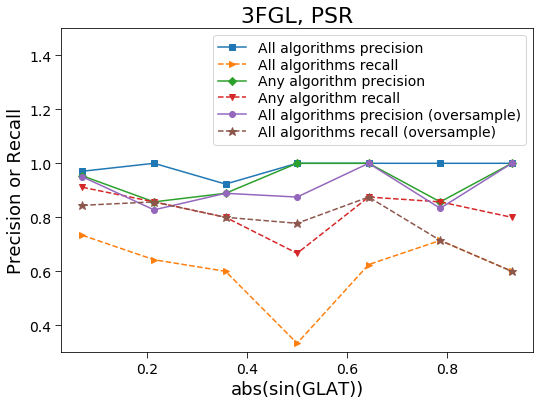

In [23]:
pyplot.figure()
for j, key in enumerate(res_dict):
    if j % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    print(key, get_label(key))
    pyplot.plot(sin_bins_c, res_dict[key], ls=ls, marker=markers[j], ms=mss[j],
                    label=get_label(key))

pyplot.xlabel('abs(sin(GLAT))')
pyplot.ylabel('Precision or Recall')
pyplot.title('%s, %s' % (cat, cls))
pyplot.legend(labelspacing=0.2)
pyplot.ylim(0.3, 1.5)

if save_plots:
    fn = '%s/all_algs_%s_precision_recall_oversample_%s.pdf' % (plots_folder, cat, cls)
    print('save figure to file: %s' % fn)
    pyplot.savefig(fn)
    if 1:
        command = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(command)
        os.system(command)


 all u
 any u
 all o


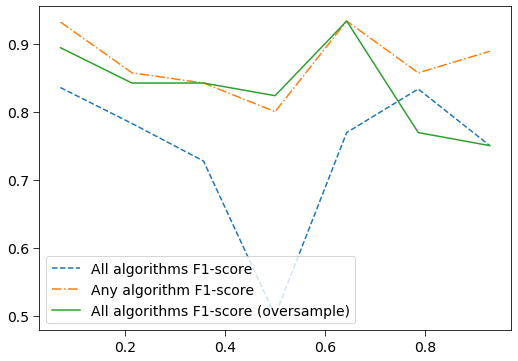

In [21]:
# f1-score plot
algs = [' all u', ' any u', ' all o']
lss = ['--', '-.', '-']
pyplot.figure()
for i, alg in enumerate(algs):
    print(alg)
    prec = res_dict['prec' + alg]
    recall = res_dict['recall' + alg]
    pyplot.plot(sin_bins_c, Fscore(prec, recall), ls=lss[i], label=get_label(alg, fscore=True))
pyplot.legend()

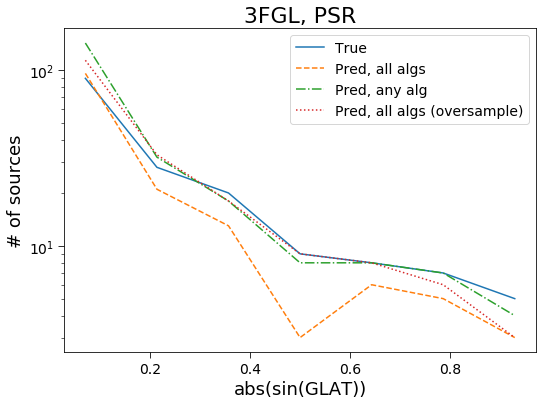

In [16]:
pyplot.figure()
pyplot.semilogy(sin_bins_c, nPSR_true, ls='-', label='True')
pyplot.semilogy(sin_bins_c, nPSR_pred_all_u, ls='--', label='Pred, all algs')
pyplot.semilogy(sin_bins_c, nPSR_pred_any_u, ls='-.', label='Pred, any alg')
pyplot.semilogy(sin_bins_c, nPSR_pred_all_o, ls=':', label='Pred, all algs (oversample)')
pyplot.xlabel('abs(sin(GLAT))')
pyplot.ylabel('# of sources')
pyplot.title('%s, %s' % (cat, cls))
pyplot.legend()

if save_plots:
    fn = '%s/source_counts_all_algs_%s_%s.pdf' % (plots_folder, cat, cls)
    print('save figure to file: %s' % fn)
    pyplot.savefig(fn)
